## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression and Elastic Net

In [1]:
import os
import pandas
from definitions import ROOT_DIR

mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape
 
X_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
X_normal['pathologic_stage'] = 'normal'
X_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}

X_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

print X_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print X_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## We now create data matrixes from tumor vs normal samples

- We do not normalize the miRNA expression values because we are using Read Per Kilobase Million Mapped

In [2]:
X = pandas.concat([X_normal, X_tumor]).dropna(subset=['pathologic_stage'])
Y = X['pathologic_stage']

X_normal_vs_I = X[X['pathologic_stage'].isin(['normal', 'Stage I'])]
X_normal_vs_II = X[X['pathologic_stage'].isin(['normal', 'Stage II'])]
X_normal_vs_III = X[X['pathologic_stage'].isin(['normal', 'Stage III'])]
X_normal_vs_IV = X[X['pathologic_stage'].isin(['normal', 'Stage IV'])]
X_I_vs_II = X[X['pathologic_stage'].isin(['Stage I', 'Stage II'])]
X_II_vs_III = X[X['pathologic_stage'].isin(['Stage II', 'Stage III'])]
X_III_vs_IV = X[X['pathologic_stage'].isin(['Stage III', 'Stage IV'])]

Y_normal_vs_I = X_normal_vs_I['pathologic_stage']
Y_normal_vs_II = X_normal_vs_II['pathologic_stage']
Y_normal_vs_III = X_normal_vs_III['pathologic_stage']
Y_normal_vs_IV = X_normal_vs_IV['pathologic_stage']
Y_I_vs_II = X_I_vs_II['pathologic_stage']
Y_II_vs_III = X_II_vs_III['pathologic_stage']
Y_III_vs_IV = X_III_vs_IV['pathologic_stage']

X_normal_vs_I.__delitem__('patient_barcode')
X_normal_vs_I.__delitem__('pathologic_stage')
X_normal_vs_II.__delitem__('patient_barcode')
X_normal_vs_II.__delitem__('pathologic_stage')
X_normal_vs_III.__delitem__('patient_barcode')
X_normal_vs_III.__delitem__('pathologic_stage')
X_normal_vs_IV.__delitem__('patient_barcode')
X_normal_vs_IV.__delitem__('pathologic_stage')
X_I_vs_II.__delitem__('patient_barcode')
X_I_vs_II.__delitem__('pathologic_stage')
X_II_vs_III.__delitem__('patient_barcode')
X_II_vs_III.__delitem__('pathologic_stage')
X_III_vs_IV.__delitem__('patient_barcode')
X_III_vs_IV.__delitem__('pathologic_stage')

X.__delitem__('patient_barcode')
X.__delitem__('pathologic_stage')

print 'miRNA null values', X.isnull().sum().sum()
print 'Y null values', Y.isnull().sum()

print "X.shape", X.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
validated_miRNAs = set(validated_miRNA_csv['miRNA'].tolist())

miRNA null values 0
Y null values 0
X.shape (552, 1881)
Y.shape (552,)


## Hyper-parameter selection for elastic net

In [6]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, Y_train, Y_test = \
    train_test_split(X_normal_vs_IV, Y_normal_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


parameters = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [1.0, 0.75, 0.6, 0.5, 0.01],
    'l1_ratio': [0.0, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95, 1.0],
    'class_weight': ['balanced'],
    'n_iter': [5, 100],
    'fit_intercept': [False]
}

grid_search = model_selection.GridSearchCV(SGDClassifier(), parameters, cv=3, n_jobs=4)
grid_search.fit(X_train, Y_train)

score_func = metrics.f1_score

print "Best %s: %0.3f" % (score_func.__name__, grid_search.best_score_)
print "Best parameters set:"
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print "\t%s: %r" % (param_name, best_parameters[param_name])

print
print "CROSS VALIDATION:"
clf = SGDClassifier(**best_parameters)
scores = model_selection.cross_val_score(clf, X_test, Y_test)
print 'Best %s: %0.3f (+/- %0.2f)' % \
    (score_func.__name__, scores.mean(), scores.std() / 2)

Best f1_score: 0.964
Best parameters set:
	alpha: 1.0
	class_weight: 'balanced'
	fit_intercept: False
	l1_ratio: 0.15
	loss: 'log'
	n_iter: 5
	penalty: 'elasticnet'

CROSS VALIDATION:
Best f1_score: 0.783 (+/- 0.01)


In [7]:
print "mirna_list", len(mirna_list)
print 'validated_miRNAs', len(validated_miRNAs)

print "number of validated miRNAs in list of all miRNAs", len(validated_miRNAs & set(mirna_list))

print Y_normal_vs_I.value_counts()
print Y_normal_vs_II.value_counts()
print Y_normal_vs_III.value_counts()
print Y_normal_vs_IV.value_counts()

mirna_list 1881
validated_miRNAs 27
number of validated miRNAs in list of all miRNAs 21
Stage I    277
normal      46
Name: pathologic_stage, dtype: int64
Stage II    121
normal       46
Name: pathologic_stage, dtype: int64
Stage III    84
normal       46
Name: pathologic_stage, dtype: int64
normal      46
Stage IV    24
Name: pathologic_stage, dtype: int64


## Split train and test data for X normal vs I, normal vs II, normal vs III and normal vs IV

In [8]:
from sklearn.model_selection import train_test_split

X_normal_vs_I_train, X_normal_vs_I_test, Y_normal_vs_I_train, Y_normal_vs_I_test = \
    train_test_split(X_normal_vs_I, Y_normal_vs_I, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_II_train, X_normal_vs_II_test, Y_normal_vs_II_train, Y_normal_vs_II_test = \
    train_test_split(X_normal_vs_II, Y_normal_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_III_train, X_normal_vs_III_test, Y_normal_vs_III_train, Y_normal_vs_III_test = \
    train_test_split(X_normal_vs_III, Y_normal_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_IV_train, X_normal_vs_IV_test, Y_normal_vs_IV_train, Y_normal_vs_IV_test = \
    train_test_split(X_normal_vs_IV, Y_normal_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


X_I_vs_II_train, X_I_vs_II_test, Y_I_vs_II_train, Y_I_vs_II_test = \
    train_test_split(X_I_vs_II, Y_I_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_II_vs_III_train, X_II_vs_III_test, Y_II_vs_III_train, Y_II_vs_III_test = \
    train_test_split(X_II_vs_III, Y_II_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_III_vs_IV_train, X_III_vs_IV_test, Y_III_vs_IV_train, Y_III_vs_IV_test = \
    train_test_split(X_III_vs_IV, Y_III_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))

## Perform classification for normal vs Stage I, Stage II, Stage III, and Stage IV 
### SGDClassifier is a linear classifier (SVM, elasticnet) that uses schochastic gradient descend


In [9]:
from sklearn import linear_model
from sklearn import metrics
import numpy as np

best_parameters['n_iter'] = 1000

normal_vs_I =   linear_model.SGDClassifier(**best_parameters)
normal_vs_II =  linear_model.SGDClassifier(**best_parameters)
normal_vs_III = linear_model.SGDClassifier(**best_parameters)
normal_vs_IV =  linear_model.SGDClassifier(**best_parameters)

I_vs_II =  linear_model.SGDClassifier(**best_parameters)
II_vs_III =  linear_model.SGDClassifier(**best_parameters)
III_vs_IV =  linear_model.SGDClassifier(**best_parameters)

print normal_vs_I.fit(X_normal_vs_I_train, Y_normal_vs_I_train)
print normal_vs_II.fit(X_normal_vs_II_train, Y_normal_vs_II_train)
print normal_vs_III.fit(X_normal_vs_III_train, Y_normal_vs_III_train)
print normal_vs_IV.fit(X_normal_vs_IV_train, Y_normal_vs_IV_train)
print I_vs_II.fit(X_I_vs_II_train, Y_I_vs_II_train)
print II_vs_III.fit(X_II_vs_III_train, Y_II_vs_III_train)
print III_vs_IV.fit(X_III_vs_IV_train, Y_III_vs_IV_train)


# print "\nClassification_report on training"
# print metrics.classification_report(y_train, model.predict(X_train), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print "classification_report on testing"
# print metrics.classification_report(y_test, model.predict(X_test), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print metrics.confusion_matrix(y_test, model.predict(X_test), 
#                                labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])

SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


## Show number of candidate miRNAs, top miRNA's based on coefficient, and percentage of known miRNA

In [11]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate
results = []

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV, I_vs_II, II_vs_III,
                        III_vs_IV],
                       ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV', 'I_vs_II',
                        'II_vs_III', 'III_vs_IV']):
    print '\n', name 
    non_zero_idx = np.nonzero(model.coef_.ravel())[0]
    print "Non-zero coef:", non_zero_idx.size
    df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                           "coefficient": model.coef_.ravel()[non_zero_idx]})

    print df.sort_values(by='coefficient', ascending=False).head(6)
    print df.sort_values(by='coefficient', ascending=True).head(6)
    
    print "Recall of miRNAs selected:", recall_rate(df['mirna'].tolist(), validated_miRNAs)
    print "Precision of miRNAs selected:", precision_rate(df['mirna'].tolist(), validated_miRNAs)

    print "Validated miRNAs selected:",set(df['mirna'].tolist()) & validated_miRNAs, len(set(df['mirna'].tolist()) & validated_miRNAs)
    
    results.append(df)

 
normal_vs_I
Non-zero coef: 91
    coefficient         mirna
28     9.360567   hsa-mir-143
11     8.671620   hsa-mir-100
8      8.013995  hsa-let-7f-2
2      7.961459  hsa-let-7a-3
7      7.905736  hsa-let-7f-1
0      7.882666  hsa-let-7a-1
    coefficient         mirna
32   -30.133907  hsa-mir-148a
55   -27.777894    hsa-mir-22
40   -18.025560   hsa-mir-182
17   -14.750283   hsa-mir-10a
51    -9.305944  hsa-mir-203a
75    -8.167810   hsa-mir-30e
Recall of miRNAs selected: 0.333333333333
Precision of miRNAs selected: 0.0989010989011
Validated miRNAs selected: set(['hsa-mir-200b', 'hsa-mir-200c', 'hsa-mir-200a', 'hsa-mir-99a', 'hsa-mir-150', 'hsa-mir-145', 'hsa-mir-155', 'hsa-mir-141', 'hsa-mir-30a']) 9

normal_vs_II
Non-zero coef: 80
    coefficient         mirna
20    13.869442   hsa-mir-143
79    11.529063   hsa-mir-99b
2      9.748110  hsa-let-7a-3
0      9.682079  hsa-let-7a-1
8      7.433135   hsa-mir-100
3      6.006054    hsa-let-7b
    coefficient         mirna
44   -27.336844

## Count number of miRNAs mutually selected between the classifiers

In [22]:
a = [[len(set(results[x]['mirna'].tolist()) & set(results[y]['mirna'].tolist())) \
      for x in range(len(results)) ] for y in range(len(results))]

print('\n'.join(['\t'.join(['{:4}'.format(item) for item in row])
      for row in a]))

 152	 119	  97	 118	 104	 116	 119
 119	 145	  92	 111	 105	 120	 112
  97	  92	 101	  91	  76	  86	  89
 118	 111	  91	 132	  97	 107	 107
 104	 105	  76	  97	 145	 113	 111
 116	 120	  86	 107	 113	 166	 118
 119	 112	  89	 107	 111	 118	 168


## Classification results

In [23]:
print metrics.classification_report(Y_normal_vs_I_test, normal_vs_I.predict(X_normal_vs_I_test),
                                    labels=['normal', 'Stage I'], 
                                    target_names=['normal', 'Stage I']) 
print metrics.classification_report(Y_normal_vs_II_test, normal_vs_II.predict(X_normal_vs_II_test), 
                                    labels=['normal', 'Stage II'], 
                                    target_names=['normal', 'Stage II']) 
print metrics.classification_report(Y_normal_vs_III_test, normal_vs_III.predict(X_normal_vs_III_test), 
                                    labels=['normal', 'Stage III'], 
                                    target_names=['normal', 'Stage III']) 
print metrics.classification_report(Y_normal_vs_IV_test, normal_vs_IV.predict(X_normal_vs_IV_test), 
                                    labels=['normal', 'Stage IV'], 
                                    target_names=['normal', 'Stage IV'])
print metrics.classification_report(Y_I_vs_II_test, I_vs_II.predict(X_I_vs_II_test), 
                                    labels=['Stage I', 'Stage II'], 
                                    target_names=['Stage I', 'Stage II'])
print metrics.classification_report(Y_II_vs_III_test, II_vs_III.predict(X_II_vs_III_test), 
                                    labels=['Stage II', 'Stage III'], 
                                    target_names=['Stage II', 'Stage III'])
print metrics.classification_report(Y_III_vs_IV_test, III_vs_IV.predict(X_III_vs_IV_test), 
                                    labels=['Stage III', 'Stage IV'], 
                                    target_names=['Stage III', 'Stage IV'])

             precision    recall  f1-score   support

     normal       0.88      0.88      0.88         8
    Stage I       0.98      0.98      0.98        57

avg / total       0.97      0.97      0.97        65

             precision    recall  f1-score   support

     normal       0.85      1.00      0.92        11
   Stage II       1.00      0.91      0.95        23

avg / total       0.95      0.94      0.94        34

             precision    recall  f1-score   support

     normal       1.00      0.90      0.95        10
  Stage III       0.94      1.00      0.97        16

avg / total       0.96      0.96      0.96        26

             precision    recall  f1-score   support

     normal       0.73      0.89      0.80         9
   Stage IV       0.67      0.40      0.50         5

avg / total       0.71      0.71      0.69        14

             precision    recall  f1-score   support

    Stage I       0.80      0.07      0.12        60
   Stage II       0.25      0.95 

## Plot manhattan plot of selected miRNAs by the classifiers

246


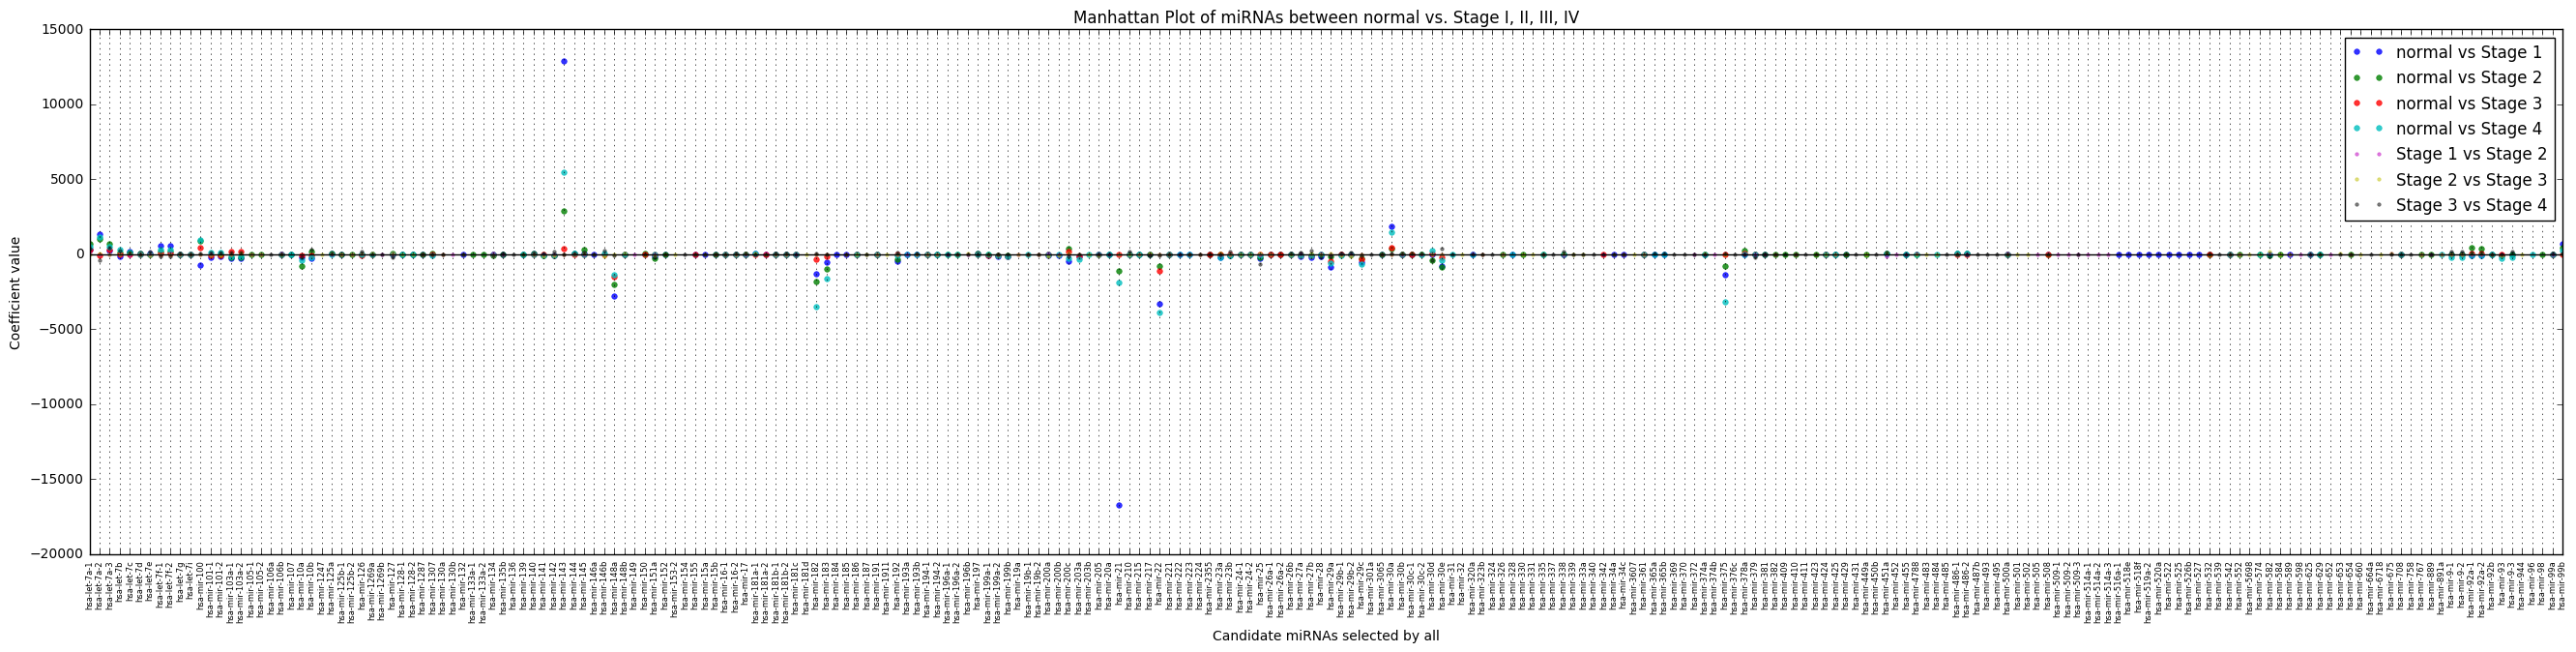

In [43]:
from matplotlib import pyplot as plt

all_candidate_miRNAs = set(results[0]['mirna']) | set(results[1]['mirna']) | set(results[2]['mirna']) | \
                       set(results[3]['mirna']) | set(results[4]['mirna']) | set(results[5]['mirna']) | \
                       set(results[6]['mirna'])
sorted_candidate_miRNAs = []
for miR in mirna_list:
    if miR in all_candidate_miRNAs:
        sorted_candidate_miRNAs.append(miR)
print sorted_candidate_miRNAs.__len__()

plt.figure(figsize=(33, 7))
plt.xticks(range(sorted_candidate_miRNAs.__len__()), sorted_candidate_miRNAs, rotation='vertical', fontsize=6)

for i in [0,1,2,3,4,5,6]:
    x_indx = []
    y_values = []
    for x_str in results[i]['mirna']:
        # print all_candidate_miRNAs.index(x_str)
        x_indx.append(sorted_candidate_miRNAs.index(x_str))

    for y_value in results[i]['coefficient']:
        y_values.append(y_value)

    if i in [0,1,2,3]:
        plt.plot(x_indx, y_values, marker='.', linestyle='', alpha=0.8, markersize=8, label='normal vs Stage '+str(i+1))
    else:
        plt.plot(x_indx, y_values, marker='.', linestyle='', alpha=0.5, markersize=5, label='Stage '+str(i-3)+' vs Stage '+str(i-2))

plt.legend()
plt.ylabel('Coefficient value')
plt.xlabel('Candidate miRNAs selected by all')
plt.title('Manhattan Plot of miRNAs between normal vs. Stage I, II, III, IV')
plt.axis('auto')
plt.gca().xaxis.grid(True)
plt.axhline(y=0, color='k')
# plt.axvline(x=0, color='k')
plt.show()